##

In [20]:
import numpy as np
import pandas as pd
import config
from rule_comparison import plot_pie_chart, get_common_rules, display_comparison, get_unique_rules
from operator import itemgetter
from kb_extension import extend_kb

# random slection of candidates
import models
from rule_mining import rule_mining
from ampligraph.latent_features import RandomBaseline

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import copy


# family dataset
#original_kb = np.loadtxt(config.family_dataset_path, dtype = 'object')
#relations = config.family_relations
#folder_path = "./family_max_entities_200/"

# wn18rr dataset
original_kb = np.loadtxt(config.wn18rr_dataset_path, dtype = 'object')
relations = config.wn18rr_relations
folder_path = "./wn18rr_max_entities_1000/"

#temp_remove
from rule_mining import rule_mining

## Load and view raw data

In [2]:
# load saved rules
original_rules = pd.read_pickle(folder_path + "original_rules.pkl")
mined_rules = pd.read_pickle(folder_path + "mined_rules.pkl")
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters.pkl")
parameter_combinations = pd.read_pickle(folder_path + "parameter_combinations.pkl")
extension_sizes = pd.read_pickle(folder_path + "extension_sizes.pkl")

#original_rules = rule_mining(original_kb) #only temp
#original_rules['PCA Confidence'] = original_rules['PCA Confidence'].apply(lambda x: float(x.replace(',','.')))
#original_rules['Head Coverage'] = original_rules['Head Coverage'].apply(lambda x: float(x.replace(',','.')))

original_rules_median_PCA = original_rules["PCA Confidence"].median()
original_rules_median_HC = original_rules["Head Coverage"].median()

In [3]:
mined_rules_parameters

,Rule,Head Coverage,PCA Confidence,Positive Examples,PCA Body size,Functional variable,Entity_selection,Model,Candidate_criteria
0,?b _derivationally_related_form ?a => ?a ...,0.999312,0.999374,31937,31957,-2,probabilistic,ComplEx,"('rank_cutoff', 1)"
1,?a _has_part ?h ?h _synset_domain_topic_of...,0.018469,0.805195,62,77,-1,probabilistic,ComplEx,"('rank_cutoff', 1)"
2,?a _instance_hypernym ?h ?h _synset_domain...,0.037831,0.830065,127,153,-1,probabilistic,ComplEx,"('rank_cutoff', 1)"
3,?g _member_meronym ?a ?g _synset_domain_to...,0.011022,0.902439,37,41,-1,probabilistic,ComplEx,"('rank_cutoff', 1)"
4,?g _has_part ?a ?g _synset_domain_topic_of...,0.025022,0.785047,84,107,-1,probabilistic,ComplEx,"('rank_cutoff', 1)"
...,...,...,...,...,...,...,...,...,...
5,?g _derivationally_related_form ?a ?g _syn...,0.041466,0.492857,138,280,-1,Original rules,Original rules,Original rules
6,?a _hypernym ?h ?h _synset_domain_topic_of...,0.213942,0.828871,712,859,-1,Original rules,Original rules,Original rules
7,?a _has_part ?h ?b _instance_hypernym ?h ...,0.035081,0.532544,180,338,-2,Original rules,Original rules,Original rules
8,?a _has_part ?h ?b _hypernym ?h => ?a ...,0.019684,0.104016,101,971,-2,Original rules,Original rules,Original rules


### Examine size of kb extension

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


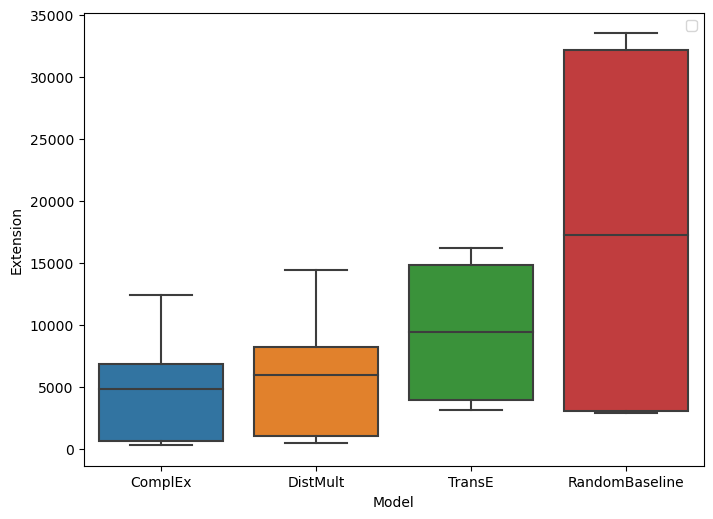

In [4]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Extension", data=extension_sizes)
#plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.legend()

## Add true randombasleine
Randomly select candidates and mine rules from the resulting expanded kb. The number of candidates to randomly add is the mean of the number of candidates added by ComplEx ranking.

In [5]:
# used to determine the number of candidates to randomly add to kb
mean_complEx_extension_size = int(extension_sizes.loc[extension_sizes["Model"] == 'ComplEx'].Extension.mean())

# construct filler model
filler_model = RandomBaseline()
filler_model.fit(original_kb)

# add rules mined from randomly selected candidates
extended_kb, admitted_candidates = extend_kb(original_kb, relations, filler_model, "random", ("random", mean_complEx_extension_size), max_entities=config.max_entities)
rules = rule_mining(extended_kb)
number_of_rules = len(rules)
parameter_list = ["Rand cand","Rand cand","Rand cand"]
parameter_full = [parameter_list for j in range(number_of_rules)]
parameter_full_df = pd.DataFrame(parameter_full, columns=["Entity_selection", "Model", "Candidate_criteria"])
original_rules_parameters= pd.concat([rules, parameter_full_df], axis=1)
original_rules_parameters['PCA Confidence'] = original_rules_parameters['PCA Confidence'].apply(lambda x: float(x.replace(',','.')))
original_rules_parameters['Head Coverage'] = original_rules_parameters['Head Coverage'].apply(lambda x: float(x.replace(',','.')))
#mined_rules.append(original_rules_parameters)
mined_rules_parameters = pd.concat([mined_rules_parameters,original_rules_parameters])

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/ampligraph/latent_features/models/EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':


In [6]:
mined_rules_parameters.to_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [7]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [8]:
# limited to rules mined with candidates ranked 1
mined_rules_parameters = mined_rules_parameters.loc[((mined_rules_parameters["Candidate_criteria"] == "('rank_cutoff', 1)") | (mined_rules_parameters["Candidate_criteria"] == 'Original rules') | (mined_rules_parameters["Candidate_criteria"] == 'Rand cand')) & ((mined_rules_parameters["Entity_selection"] == 'least_frequent') | (mined_rules_parameters["Entity_selection"] == 'Rand cand'))]

## Parameter 1: embedding model

In [9]:
def get_dataframe_to_plot(all_rules, parameter_type, parameter_name):
    """
    Generate dataframe containing rules mined with certain parameter value
    """
    rules = all_rules.loc[(all_rules[parameter_type] == parameter_name)]
    return rules

### Parameter 1: KG embeddings

In [11]:
complEx_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "ComplEx")
distMult_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "DistMult")
transE_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "TransE")
randomBaseline_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "RandomBaseline")
random_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "Rand cand")

In [12]:
complEx_PCA_mean = complEx_rules['PCA Confidence'].mean()
distMult_PCA_mean = distMult_rules['PCA Confidence'].mean()
transE_PCA_mean = transE_rules['PCA Confidence'].mean()
randomBaseline_PCA_mean = randomBaseline_rules['PCA Confidence'].mean()
random_PCA_mean = random_rules['PCA Confidence'].mean()

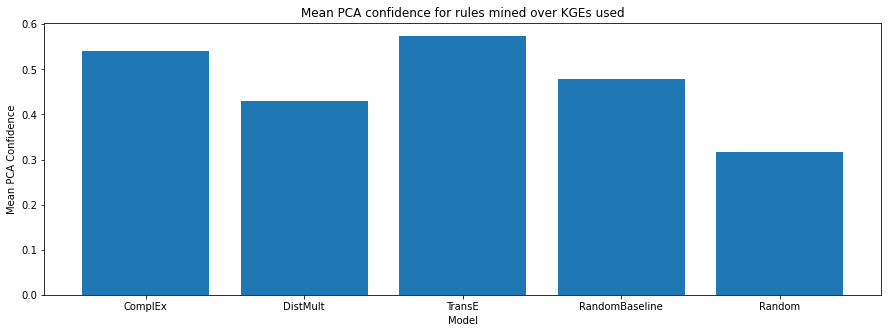

In [13]:
names = ["ComplEx", "DistMult", "TransE", "RandomBaseline", "Random"]
values = [complEx_PCA_mean, distMult_PCA_mean, transE_PCA_mean, randomBaseline_PCA_mean, random_PCA_mean]
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.ylabel('Mean PCA Confidence')
plt.xlabel('Model')
plt.title("Mean PCA confidence for rules mined over KGEs used");

In [14]:
complEx_rules[0:50]

,Rule,Head Coverage,PCA Confidence,Positive Examples,PCA Body size,Functional variable,Entity_selection,Model,Candidate_criteria
0,?b _derivationally_related_form ?a => ?a ...,0.998061,0.999186,31918,31944,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
1,?a _instance_hypernym ?h ?h _synset_domain...,0.037080,0.841060,127,151,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
2,?g _has_part ?a ?g _synset_domain_topic_of...,0.025693,0.765217,88,115,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
3,?a _has_part ?h ?h _synset_domain_topic_of...,0.019562,0.788235,67,85,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
4,?a _derivationally_related_form ?h ?h _syn...,0.041460,0.471761,142,301,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
5,?g _derivationally_related_form ?a ?g _syn...,0.041460,0.471761,142,301,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
6,?a _hypernym ?h ?h _synset_domain_topic_of...,0.210803,0.810325,722,891,-1,least_frequent,ComplEx,"('rank_cutoff', 1)"
7,?a _has_part ?h ?b _instance_hypernym ?h ...,0.035301,0.497326,186,374,-2,least_frequent,ComplEx,"('rank_cutoff', 1)"
8,?a _has_part ?h ?h _member_meronym ?b =...,0.012992,0.308605,104,337,-2,least_frequent,ComplEx,"('rank_cutoff', 1)"
9,?a _has_part ?h ?b _hypernym ?h => ?a ...,0.022775,0.114613,120,1047,-2,least_frequent,ComplEx,"('rank_cutoff', 1)"



complEx
Mined 10/10 original rules, and 3 new rules.


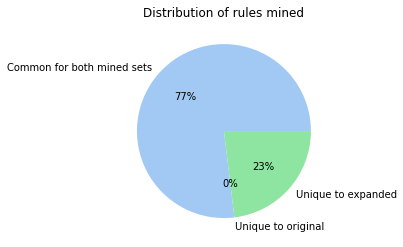


distMult
Mined 10/10 original rules, and 30 new rules.


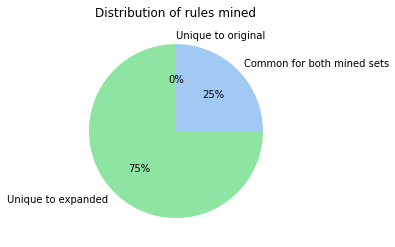


transE
Mined 9/10 original rules, and 608 new rules.
Rules missed:
?a  _derivationally_related_form  ?h  ?h  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b


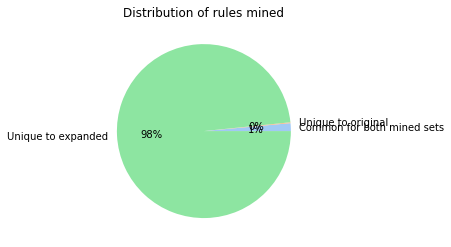


randomBaseline
Mined 8/10 original rules, and 0 new rules.
Rules missed:
?a  _has_part  ?h  ?b  _hypernym  ?h   => ?a  _has_part  ?b


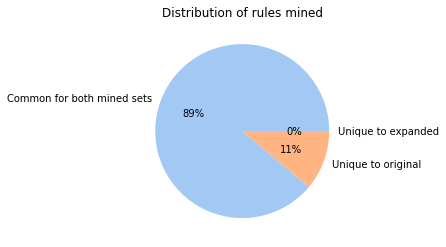


random
Mined 8/10 original rules, and 0 new rules.
Rules missed:
?a  _has_part  ?h  ?b  _hypernym  ?h   => ?a  _has_part  ?b


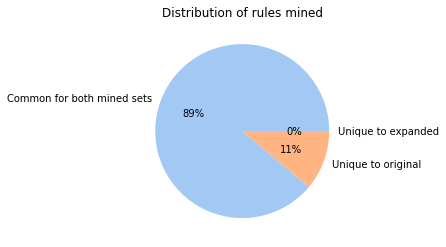

In [15]:
display_comparison("complEx", original_rules, complEx_rules.drop_duplicates("Rule"))
display_comparison("distMult", original_rules, distMult_rules.drop_duplicates("Rule"))
display_comparison("transE", original_rules, transE_rules.drop_duplicates("Rule"))
display_comparison("randomBaseline", original_rules, randomBaseline_rules.drop_duplicates("Rule"))
display_comparison("random", original_rules, random_rules.drop_duplicates("Rule"))

In [16]:
#def get_rule_distribution_dataframe(original_rules, mined_rules):
models = mined_rules_parameters.Model.unique()
rule_set_A = original_rules
rule_dist_df = pd.DataFrame([], columns = ["Model", "Not found", "Found", "New"])
for model in models:
    if model == "Original rules":
        continue
    rule_set_B = mined_rules_parameters.loc[(mined_rules_parameters['Model'] == model)].drop_duplicates(['Rule'])
    common = get_common_rules(rule_set_A, rule_set_B)
    unique_A, unique_B = get_unique_rules(rule_set_A, rule_set_B)
    common = len(common)
    len_unique_A = len(unique_A)
    len_unique_B = len(unique_B)
    append_df = pd.DataFrame([[model, len_unique_A, common, len_unique_B]], columns = ["Model", "Not found", "Found", "New"])
    rule_dist_df = rule_dist_df.append(append_df)
rule_dist_df

,Model,Not found,Found,New
0,ComplEx,0,10,3
0,DistMult,0,10,30
0,TransE,1,9,608
0,RandomBaseline,1,8,0
0,Rand cand,1,8,0


Text(4, -0.05, '10')

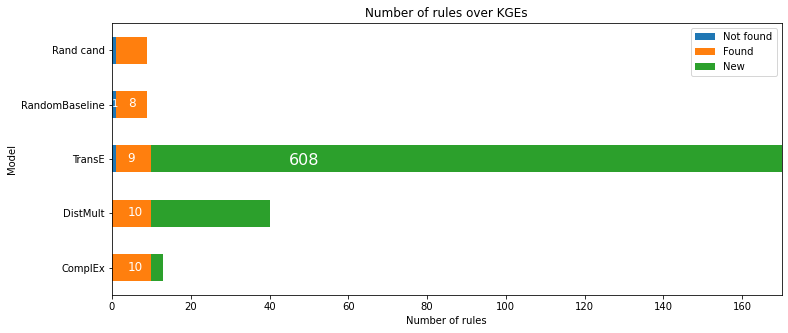

In [17]:
df = pd.DataFrame(rule_dist_df.set_index('Model'))
ax = df.plot.barh(figsize = (12, 5), title = "Number of rules over KGEs", stacked=True, xlim = (0,170), legend = True)
ax.set_xlabel('Number of rules')
randomBaseline_not_found_rules = 1 # TODO
ax.annotate(str(randomBaseline_not_found_rules), xy =(0.08,2.95), color = "white")
randomBaseline_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'RandomBaseline')].Found.values[0]
ax.annotate(str(randomBaseline_found_rules), xy =(4,2.95), color = "white", fontsize=12)
transE_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].New.values[0]
ax.annotate(str(transE_new_rules), xy =(45,1.9), color = "white", fontsize=16)
transE_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].Found.values[0]
ax.annotate(str(transE_found_rules), xy =(4,1.95), color = "white", fontsize=12)
distMult_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].New.values[0]
ax.annotate(str(distMult_new_rules), xy =(45,0.95), color = "white", fontsize=12)
distMult_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].Found.values[0]
ax.annotate(str(distMult_found_rules), xy =(4,0.95), color = "white", fontsize=12)
complEx_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].New.values[0]
ax.annotate(str(complEx_new_rules), xy =(18,-0.05), color = "white", fontsize=12)
complEx_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].Found.values[0]
ax.annotate(str(complEx_found_rules), xy =(4,-0.05), color = "white", fontsize=12)

In [24]:
def parse_rule(string_rule: str):
    list_rule = string_rule.split()
    body_1 = [list_rule[0], list_rule[1], list_rule[2]]
    body_parts = [body_1]
    if len(list_rule) > 7:
        body_2 = [list_rule[3], list_rule[4], list_rule[5]]
        body_parts.append(body_2)
        head = [list_rule[7], list_rule[8], list_rule[9]]
    else:
        head = [list_rule[4], list_rule[5], list_rule[6]]
    return body_parts, head

In [31]:
b, h = parse_rule(transE_rules.drop_duplicates("Rule").Rule[0])

In [32]:
b

[['?b', '_has_part', '?a']]

In [33]:
h

['?a', '_synset_domain_topic_of', '?b']

In [34]:
for rule in transE_rules.drop_duplicates("Rule").Rule:
    print(rule)

?b  _has_part  ?a   => ?a  _synset_domain_topic_of  ?b
?b  _hypernym  ?a   => ?a  _synset_domain_topic_of  ?b
?b  _synset_domain_topic_of  ?a   => ?a  _synset_domain_topic_of  ?b
?a  _member_meronym  ?b   => ?a  _synset_domain_topic_of  ?b
?b  _derivationally_related_form  ?a   => ?a  _synset_domain_topic_of  ?b
?a  _has_part  ?b   => ?a  _synset_domain_topic_of  ?b
?b  _member_meronym  ?a   => ?a  _synset_domain_topic_of  ?b
?a  _derivationally_related_form  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _hypernym  ?b   => ?a  _synset_domain_topic_of  ?b
?b  _synset_domain_topic_of  ?a   => ?a  _has_part  ?b
?b  _hypernym  ?a   => ?a  _has_part  ?b
?a  _derivationally_related_form  ?b   => ?a  _has_part  ?b
?b  _member_meronym  ?a   => ?a  _has_part  ?b
?b  _derivationally_related_form  ?a   => ?a  _has_part  ?b
?a  _synset_domain_topic_of  ?b   => ?a  _has_part  ?b
?a  _hypernym  ?b   => ?a  _has_part  ?b
?a  _member_meronym  ?b   => ?a  _has_part  ?b
?b  _has_part  ?a   => ?a  _has_par

In [19]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [ ]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.title("PCA Confidence for each model")
plt.legend()
plt.savefig("Max_entities=250_randcand=600_rank=1.png")

In [ ]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each model")
plt.legend()

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["PCA Confidence"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["PCA Confidence"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot(randomBaseline_rules["PCA Confidence"] , color="black", bins = 100, label="RandomBaseline")


plt.title('PCA Confidence distribution for KG embeddings')
plt.legend();

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["Head Coverage"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["Head Coverage"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot( randomBaseline_rules["Head Coverage"] , color="black", bins = 100, label="RandomBaseline")


plt.title('Head Coverage distribution for KG embeddings')
plt.legend();

### Parameter 2: entity selection method

In [ ]:
random_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "random")
most_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "most_frequent")
least_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "least_frequent")
probabilistic_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "probabilistic")

In [ ]:
display_comparison("Random selecction", original_rules, random_entity_rules.drop_duplicates("Rule"))
display_comparison("Most frequent", original_rules, most_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("least frequent", original_rules, least_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("Probabilistic selection", original_rules, probabilistic_entity_rules.drop_duplicates("Rule"))

In [ ]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for each entity selection method")
plt.legend()


In [ ]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each entity selection method")
plt.legend()

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["PCA Confidence"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["PCA Confidence"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["PCA Confidence"] , color="black", bins = 100, label="random")


plt.title('PCA Confidence distribution for entity selection methods')
plt.legend();

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["Head Coverage"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["Head Coverage"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["Head Coverage"] , color="black", bins = 100, label="random")


plt.title('Head Coverage distribution for entity selection methods')
plt.legend();

### Parameter 3: candidate admittance criteria

In [ ]:
mined_rules_parameters['Candidate_criteria'] =  mined_rules_parameters.Candidate_criteria.astype(str)

for rank in config.rank_cutoffs:
    rank_df = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    display_comparison(str(rank), original_rules, rank_df.drop_duplicates("Rule"))

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for candidate admittance criteria")

plt.legend()

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for candidate admittance criteria")
plt.legend()

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["PCA Confidence"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('PCA Confidence distribution for candidate admittance criteria')
plt.legend();

In [ ]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["Head Coverage"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('Head Coverage distribution for candidate admittance criteria')
plt.legend();

### PCA Confidence vs Head Coverage

These plots visualize too many datapoints so it is only confusing to look at these plots

In [ ]:
def plot_scatterplot(mined_rules_df, parameter="Model"):
    plt.subplots(figsize=(12,6), dpi=100)
    plot = sns.scatterplot(data=mined_rules_df.sample(frac=1), x="PCA Confidence", y="Head Coverage", hue=parameter, alpha=1)
    #plot.set_xlim(0.09, 0.5)
    #plot.set_ylim(0, 0.16)
    plot.set_title("PCA Confidence vs Head coverage per " +parameter.lower())
    plt.legend()

In [ ]:
plot_scatterplot(mined_rules_parameters, parameter="Model")

In [ ]:
plot_scatterplot(mined_rules_parameters, parameter="Entity_selection")

In [ ]:
plot_scatterplot(mined_rules_parameters, parameter="Candidate_criteria")